In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [2]:
release=None

In [6]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-31,2021-01-28,United Kingdom,K02000001,22860,NaN,820.0,753031.0
1,2021-01-31,2021-01-27,United Kingdom,K02000001,25441,3039.0,905.0,771710.0
2,2021-01-31,2021-01-26,United Kingdom,K02000001,26852,3120.0,920.0,596845.0
3,2021-01-31,2021-01-25,United Kingdom,K02000001,29805,2903.0,1069.0,542893.0
4,2021-01-31,2021-01-24,United Kingdom,K02000001,17171,3096.0,1036.0,412204.0
...,...,...,...,...,...,...,...,...
360,2021-01-31,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
361,2021-01-31,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
362,2021-01-31,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
363,2021-01-31,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [7]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-31.csv')

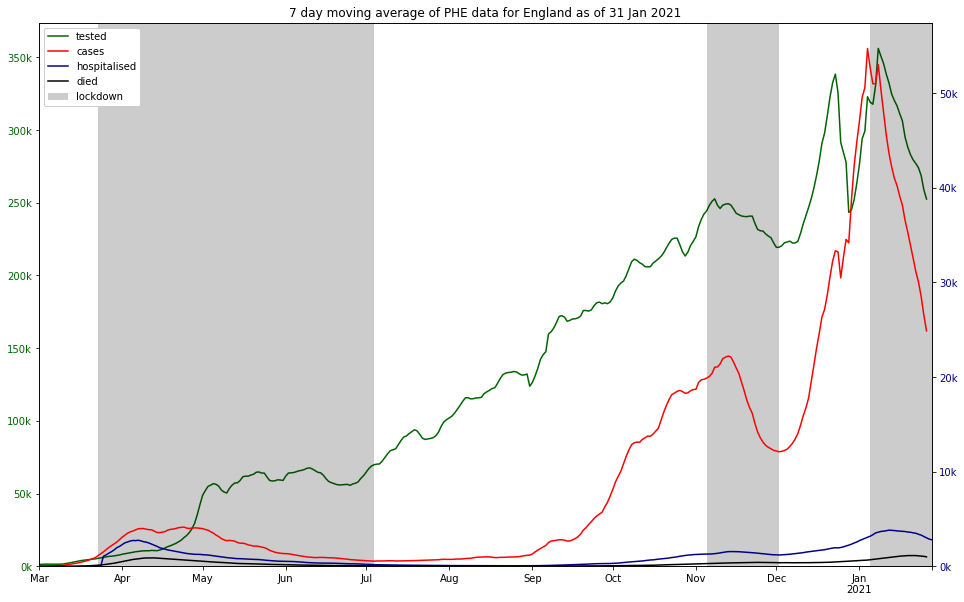

In [8]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [9]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-31.csv')

In [10]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-31.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,24323.0,214601.0,190278.0,1893667,1.284439,10.048124,88.667437
1,Scotland,S92000003,7794.0,566269.0,558475.0,5463300,0.142661,10.222302,89.635037
2,Wales,W92000004,786.0,403463.0,402677.0,3152879,0.024930,12.771724,87.203347
3,England,E92000001,458150.0,7792996.0,7334846.0,56286961,0.813954,13.031164,86.154882


'8,977,329'

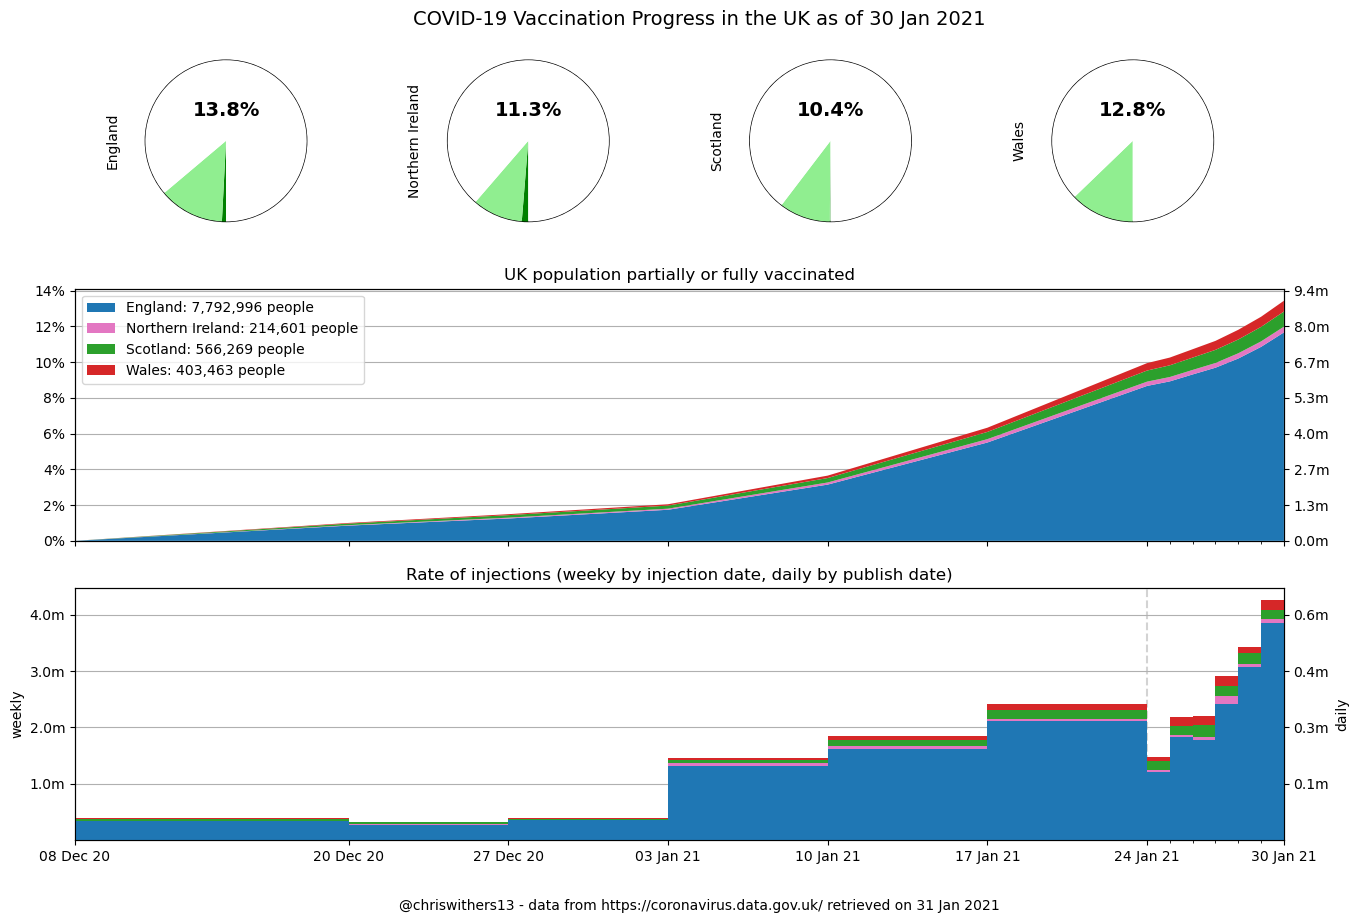

In [3]:
results = vaccination_dashboard()
display(results)
f"{results['any'].sum():,.0f}"

In [4]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,30 Jan 21,"+539,691","+10,252","+10,252","+7,792,996","+458,150","+458,150"
Northern Ireland,30 Jan 21,"+10,536",+177,+177,"+214,601","+24,323","+24,323"
Scotland,30 Jan 21,"+22,899",+156,+156,"+566,269","+7,794","+7,794"
Wales,30 Jan 21,"+25,263",+36,+36,"+403,463",+786,+786


In [13]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-31.csv')

In [14]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-31.csv')

In [15]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-31.csv')

In [16]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-31, release: 2021-01-31 16:00:04.598911+00:00, msoa: 2021-01-31 16:19:18+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-31.csv')